Step $1$: rotation of the image, such that the bounding box is perfectly aligned with the image axes. In other words, rotation of the image s.t. the barcode bars are perfectly vertical.

Actually, this last definition is not exactly True, since, if the barcode is rotated (i.e. horizontal bars), then the bounding box is placed perfectly aligned with the images axes, but the bars are not perfectly vertical (they are perfectly horizontal).

This step $1$ rotates both the image and the bounding box.

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
import math

In [3]:
import importlib  
module = importlib.import_module('1) detect_roi')
detect_roi = module.detect_roi

In [4]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('../images') if isfile(join('../images', f))]

In [5]:
image_path = f'../images/{images_paths[26]}'

(1024, 1280, 3)


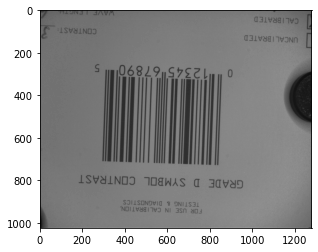

In [6]:
# load the image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')
plt.title('Original image')

array([[296., 246.],
       [873., 265.],
       [280., 726.],
       [857., 745.]], dtype=float32)

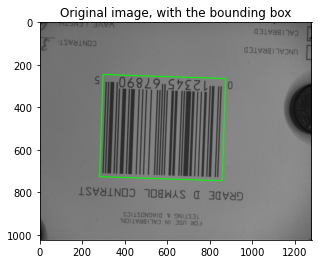

In [7]:
bb_points_sorted, bb_width, bb_height = detect_roi(image, visualize_bounding_box=True)
bb_points_sorted

## COMPUTING THE BOUNDING BOX ORIENTATION

First of all, let's compute the bounding box orientation. Namely, the angle between the rectangle and the horizontal axis.

We can compute $4$ different such angles: angle between the points $1,2$; angle between the points $2,1$; angle between the points $3,4$; angle between the points $4,3$. (Of course, the first two angles should be the same, and also the last two angles). This ordering of the bounding box points is the one decided by the `detect_roi` function.

An angle between two points $P_i,P_j$ is computed as the `arctan` of the slope $m$ of the line between the two points.

In [8]:
point1 = bb_points_sorted[0, :]
point2 = bb_points_sorted[1, :]
point3 = bb_points_sorted[2, :]
point4 = bb_points_sorted[3, :]

In [9]:
angle1 = abs(math.degrees(math.atan((point2[1]-point1[1])/(point2[0]-point1[0]))))
print(angle1)

angle2 = abs(math.degrees(math.atan((point4[1]-point3[1])/(point4[0]-point3[0]))))
print(angle2)

angle3 = 90-abs(math.degrees(math.atan((point1[1]-point3[1])/(point1[0]-point3[0]))))
print(angle3)

angle4 = 90-abs(math.degrees(math.atan((point2[1]-point4[1])/(point2[0]-point4[0]))))
print(angle4)

1.8860080152490561
1.8860080152490561
1.909152432996379
1.909152432996379


As expected, the first two angles are the same, and also the last two angles are the same. 

On the whole, we take as the orientation of the bounding box the mean between the two angles values.

In [11]:
angle = (angle1+angle3)/2
angle

1.8975802241227175

## ROTATING THE IMAGE

Now, we want to rotate the image by means of this angle. We want to use the first point of the bounding box as the centre of this rotation trasformation.

Performing a rotation means performing a warping.

In [12]:
def rotate_image(image, angle, center):
  # Rotation matrix
  rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
  # Rotated image
  image_rot = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return image_rot, rot_mat

Text(0.5, 1.0, 'Rotated image')

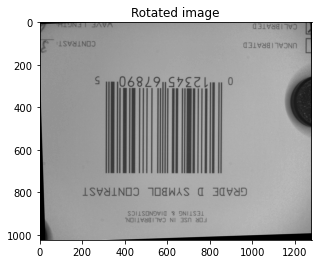

In [13]:
gray_rot, rot_mat = rotate_image(gray, angle=angle, center=point1)
plt.imshow(gray_rot, 'gray')
plt.title('Rotated image')

Text(0.5, 1.0, 'Difference rotated non-rotated')

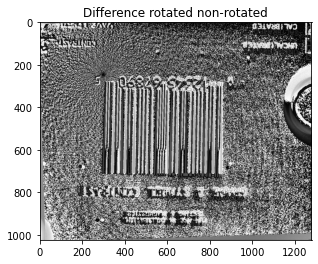

In [14]:
plt.imshow(abs(gray_rot-gray), 'gray')
plt.title('Difference rotated non-rotated')

As it can be seen, the rotation centre is the first point of the bounding box (i.e. the upper-left vertex).

## WHAT IF THE ANGLE IS $0$?

It can happen that the angle is $0$: this means that the bounding box is already perfectly aligned. In such case, no rotation is performed.

(1024, 1280, 3)


<ipython-input-25-9cf7892f51ef>:17: RuntimeWarning: divide by zero encountered in float_scalars
  angle3 = 90-abs(math.degrees(math.atan((point1[1]-point3[1])/(point1[0]-point3[0]))))
<ipython-input-25-9cf7892f51ef>:18: RuntimeWarning: divide by zero encountered in float_scalars
  angle4 = 90-abs(math.degrees(math.atan((point2[1]-point4[1])/(point2[0]-point4[0]))))


0.0

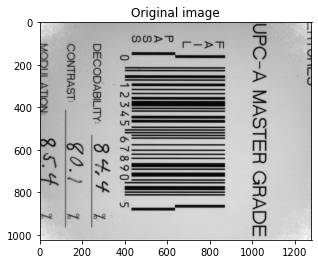

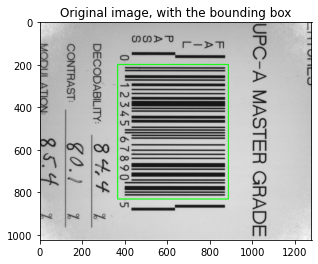

In [25]:
image_path = f'../images/{images_paths[12]}'
# load the image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')
plt.title('Original image')

bb_points_sorted, bb_width, bb_height = detect_roi(image, visualize_bounding_box=True)

point1 = bb_points_sorted[0, :]
point2 = bb_points_sorted[1, :]
point3 = bb_points_sorted[2, :]
point4 = bb_points_sorted[3, :]
angle1 = abs(math.degrees(math.atan((point2[1]-point1[1])/(point2[0]-point1[0]))))
angle2 = abs(math.degrees(math.atan((point4[1]-point3[1])/(point4[0]-point3[0]))))
angle3 = 90-abs(math.degrees(math.atan((point1[1]-point3[1])/(point1[0]-point3[0]))))
angle4 = 90-abs(math.degrees(math.atan((point2[1]-point4[1])/(point2[0]-point4[0]))))

angle = (angle1+angle3)/2
angle

## ROTATING THE BOUNDING BOX
Let's now define the rotated bounding box. It is very easy to define it, and we don't need to rotate anything. Since the rotation centre is the first point of the bounding box, and since the rotated bounding box is aligned with the image axes, we can define the rotated bounding box by simply considering the bounding box width and height.

In [16]:
bb_points_sorted_rot = np.array([point1,
                          [point1[0]+bb_width-1, point1[1]],
                          [point1[0], point1[1]+bb_height-1],
                          [point1[0]+bb_width-1, point1[1]+bb_height-1]], dtype='float32') 

## VISUALIZATION

Let's visualize the rotated image, plus the rotated bounding box.

Text(0.5, 1.0, 'Rotated image')

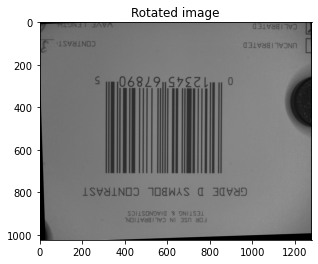

In [17]:
image_rot, rot_mat = rotate_image(image, angle=angle, center=point1)
plt.imshow(image_rot, 'gray')
plt.title('Rotated image')

In [21]:
# Function which sorts the bb points differently, for making the bb compliant with the visualization API
def sort_bb_points_for_visualization(bb_points_sorted):
    bb_rot = bb_points_sorted.copy()
    bb_rot[2, :] = bb_sorted_rot[3, :]
    bb_rot[3, :] = bb_sorted_rot[2, :]
    return bb_rot.astype(int)

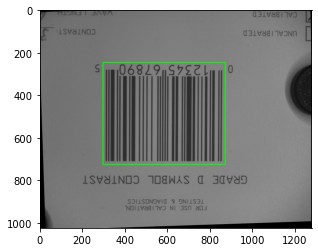

In [22]:
# Draw a bounding box around the detected barcode and display the image
image_rot_bb = image_rot.copy()
cv2.drawContours(image_rot_bb, [sort_bb_points_for_visualization(bb_points_sorted_rot)], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_rot_bb, 'gray')

## ROI IMAGE

Finally, we can crop the rotated image around the rotated bounding box for getting the ROI image.

In [23]:
roi_image = gray_rot[int(bb_points_sorted_rot[0][1]):int(bb_points_sorted_rot[0][1]+bb_height), 
                     int(bb_points_sorted_rot[0][0]):int(bb_points_sorted_rot[0][0]+bb_width)]

Text(0.5, 1.0, 'ROI image')

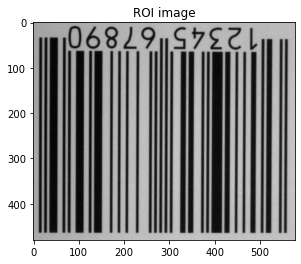

In [24]:
plt.figure()
plt.imshow(roi_image, 'gray')
plt.title('ROI image')

The barcode bars are perfectly vertical!!! However, problem: what if the barcode is rotated (i.e. horizontal bars)? The bars are perfectly horizontal, not perfectly vertical: we have to fix that. Step $2$.